手搓贝叶斯网状Meta分析，我要手搓搓爆一切！

# 基于比较的建模策略

## 固定效应模型

In [51]:
library(R2jags)

In [52]:
library(tidyverse)

In [53]:
PFS <- read_csv("./data/PFS.csv")
PFS

Rows: 14 Columns: 9
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (2): Trial, Treat
dbl (7): TE, LCI, UCI, isReport, isNew, isAsia, isChina

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


Trial,TE,LCI,UCI,Treat,isReport,isNew,isAsia,isChina
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
DB04,0.51,0.40,0.64,TDxd,1,1,0,0
DB04,NA,NA,NA,Chem,1,1,0,0
DB04_Asia,0.41,0.28,0.58,TDxd,0,0,1,1
DB04_Asia,NA,NA,NA,Chem,0,0,1,1
T02,0.65,0.53,0.81,SG,1,1,0,0
T02,NA,NA,NA,Chem,1,1,0,0
EVER,0.67,0.52,0.87,SG,0,1,1,1
EVER,NA,NA,NA,Chem,0,1,1,1
TB01,0.63,0.52,0.76,Dato,1,1,0,0


In [54]:
# 预处理数据
data_PFS <- PFS %>% 
  filter(
    isReport == 1,
  ) %>% 
  mutate(
    TE = log(TE),
    SE = (log(UCI) - log(LCI)) / (2 * 1.96)
  )  %>% 
  rename(
    study = Trial,
    diff = TE,
    std.err = SE,
    treatment = Treat
  ) %>% 
  select(
    study,
    treatment,
    diff,
    std.err
  )

data_PFS

study,treatment,diff,std.err
<chr>,<chr>,<dbl>,<dbl>
DB04,TDxd,-0.6733446,0.11989889
DB04,Chem,NA,NA
T02,SG,-0.4307829,0.10820338
T02,Chem,NA,NA
TB01,Dato,-0.4620355,0.09680858
TB01,Chem,NA,NA


In [55]:
# 构建函数，放入数据，返回结果
NMA_one_step <- function(data, treat_codes, file_name) {
  # data是处理好的标准数据集，列名为study, treatment, diff, std.err
  # treat_codes是处理好的治疗代码对应表
  # file_name是结果保存的文件名

  # 构建模型
  network <- mtc.network(
    data.re = data,
    treatments = treat_codes
  )

  model <- mtc.model(
    network = network,
    likelihood = "normal",
    link = "identity",
    linearModel = "fixed",
    n.chain = 2,
    re.prior.sd = 100, # 方差为10000
  )

  # 运行模型
  mcmc <- mtc.run(
    model = model,
    n.adapt = 20000,
    n.iter = 30000,
    thin = 10
  )

  # 绘制秩图
  rank <- rank.probability(mcmc, preferredDirection = -1)
  plot(rank, besid = TRUE)

  # 森林图
  gemtc::forest(
    relative.effect(mcmc, t1 = "Chem"),
    use.description = TRUE,
    xlim = c(-1.5, 0.5)
  )

  # 返回结果
  results <- round(exp(relative.effect.table(mcmc)), 2)
  print(results)
}

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 3
   Unobserved stochastic nodes: 3
   Total graph size: 58

Initializing model



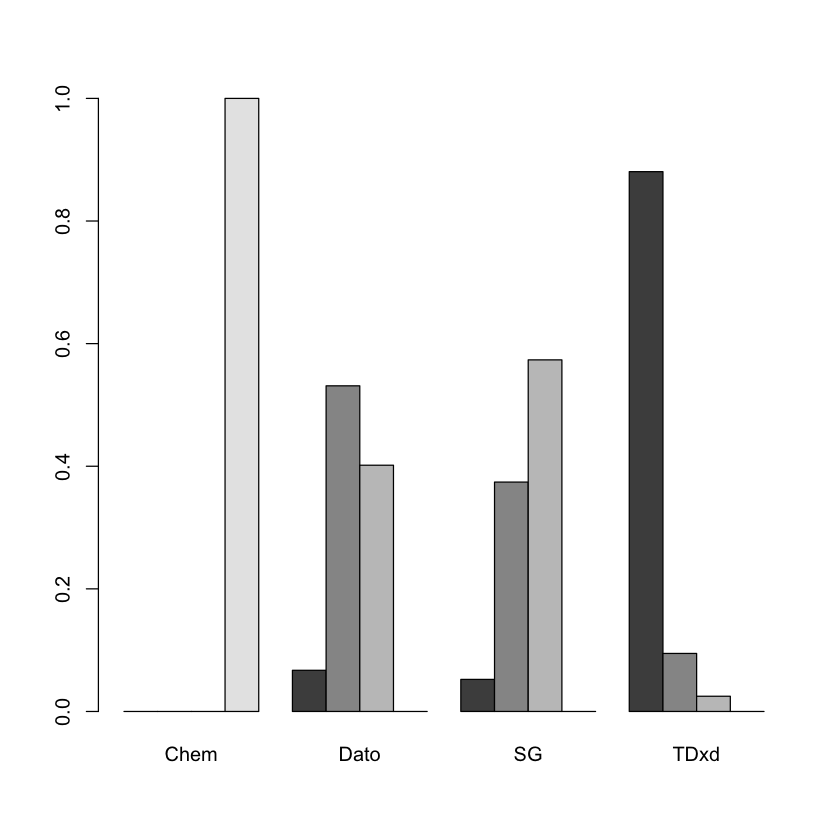

Mean Difference (95% CrI)

      Chem        0.51 (0.4, 0.64)  0.65 (0.53, 0.8)  0.63 (0.52, 0.76)
1.97 (1.55, 2.49)       TDxd        1.28 (0.93, 1.74) 1.24 (0.93, 1.67)
1.53 (1.25, 1.89) 0.78 (0.57, 1.08)        SG         0.97 (0.73, 1.29)
1.58 (1.31, 1.91)  0.8 (0.6, 1.08)  1.03 (0.77, 1.37)       Dato       


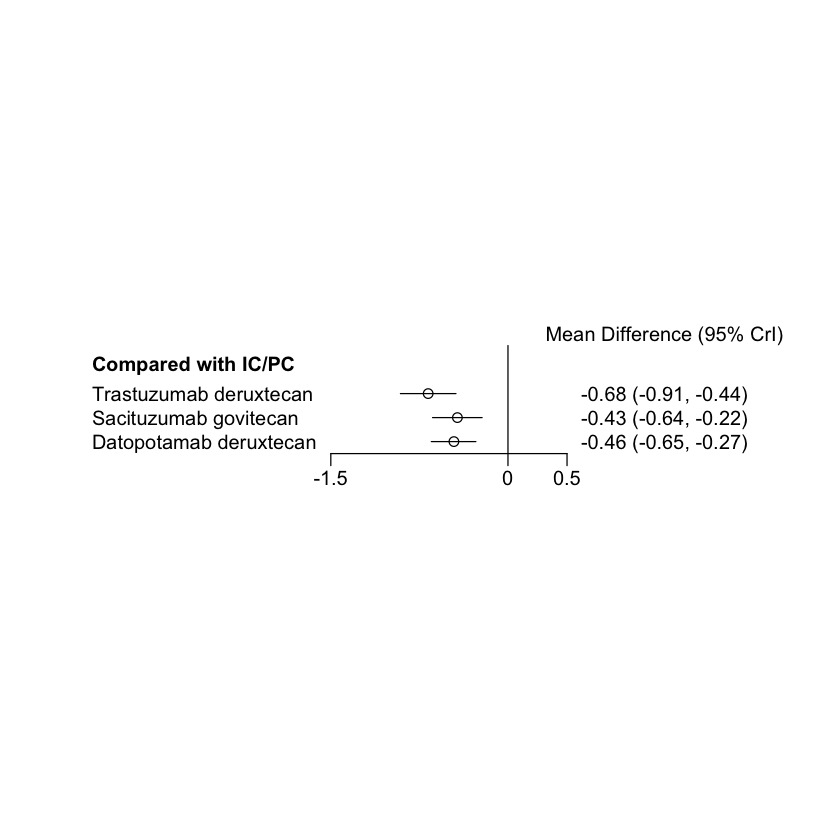

In [56]:
# 导入必要的包
library(gemtc)

# 设置种子
set.seed(12345)

# 提供实际名称
treat_simple <- c("Chem", "TDxd", "SG", "Dato")
treat_complete <- c(
  "IC/PC",
  "Trastuzumab deruxtecan",
  "Sacituzumab govitecan",
  "Datopotamab deruxtecan"
)

treat_codes <- data.frame(
  id = treat_simple,
  description = treat_complete
)

NMA_one_step(data_PFS, treat_codes)

In [57]:
# 删掉NA的行
data_PFS <- data_PFS %>% 
  filter(!is.na(diff))

data_PFS

study,treatment,diff,std.err
<chr>,<chr>,<dbl>,<dbl>
DB04,TDxd,-0.6733446,0.11989889
T02,SG,-0.4307829,0.10820338
TB01,Dato,-0.4620355,0.09680858


In [58]:
# Chem编码为1
# TDxd编码为2
# SG编码为3
# Dato编码为4

# 准备数据
data <- list(
  N = 3, # 3个研究
  K = 4, # 4个治疗
  TE = data_PFS$diff,  # 效应
  SE = data_PFS$std.err  # 标准差
)

data

$N
[1] 3

$K
[1] 4

$TE
[1] -0.6733446 -0.4307829 -0.4620355

$SE
[1] 0.11989889 0.10820338 0.09680858

In [59]:
parmas <- c("exp_mu_21", "exp_mu_31", "exp_mu_41", "exp_mu_32", "exp_mu_42", "exp_mu_43")

# 定义模型
model <- function() {
  # 第一层，数据层
  # DB04
  W_1 <- 1 / (SE[1]^2)
  TE[1] ~ dnorm(mu_21, W_1)
  # T02
  W_2 <- 1 / (SE[2]^2)
  TE[2] ~ dnorm(mu_31, W_2)
  # TB01
  W_3 <- 1 / (SE[3]^2)
  TE[3] ~ dnorm(mu_41, W_3)

  # 第二层，先验层
  mu_21 ~ dnorm(0, 0.0001)
  mu_31 ~ dnorm(0, 0.0001)
  mu_41 ~ dnorm(0, 0.0001)

  # 返回结果
  mu_32  <- mu_31 - mu_21
  mu_42  <- mu_41 - mu_21
  mu_43  <- mu_41 - mu_31

  # 结果转化
  exp_mu_21 <- exp(mu_21)
  exp_mu_31 <- exp(mu_31)
  exp_mu_41 <- exp(mu_41)
  exp_mu_32 <- exp(mu_32)
  exp_mu_42 <- exp(mu_42)
  exp_mu_43 <- exp(mu_43)
}

# 定义种子
set.seed(12345)

# 运行模型
result <- jags(
  data = data,
  parameters.to.save = parmas,
  model.file = model,
  n.chains = 2,
  n.iter = 30000,
  n.burnin = 20000,
  n.thin = 10
)

# 结果
result

Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
"Unused variable "N" in data"
Warning message in jags.model(model.file, data = data, inits = init.values, n.chains = n.chains, :
"Unused variable "K" in data"


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 3
   Unobserved stochastic nodes: 3
   Total graph size: 28

Initializing model



Inference for Bugs model at "/var/folders/fv/c0dh9y6s7638rh5fdr3lgcmr0000gn/T//Rtmpwpukcm/model1636a790ba742.txt", fit using jags,
 2 chains, each with 30000 iterations (first 20000 discarded), n.thin = 10
 n.sims = 2000 iterations saved. Running time = 0.02 secs
          mu.vect sd.vect   2.5%    25%    50%    75% 97.5%  Rhat n.eff
exp_mu_21   0.514   0.061  0.405  0.471  0.510  0.549 0.646 1.001  2000
exp_mu_31   0.655   0.070  0.531  0.605  0.652  0.699 0.801 1.001  2000
exp_mu_32   1.292   0.208  0.935  1.147  1.271  1.421 1.733 1.002  2000
exp_mu_41   0.633   0.061  0.525  0.591  0.631  0.670 0.763 1.001  2000
exp_mu_42   1.250   0.188  0.911  1.118  1.242  1.372 1.653 1.001  2000
exp_mu_43   0.980   0.145  0.726  0.877  0.967  1.072 1.287 1.001  2000
deviance   -4.917   2.388 -7.657 -6.684 -5.531 -3.775 1.146 1.001  2000

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (us

# 基于臂的建模策略

In [60]:
# 读取数据
pdata <- read_csv("./data/pdata.csv")
pdata

Rows: 16 Columns: 7
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (2): code, treatment
dbl (5): study, trtcode, mean, sd, n

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


study,code,trtcode,treatment,mean,sd,n
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,Lieberman 1997,1,Placebo,-0.70,3.70,172
1,Lieberman 1997,2,Pramipexole,-2.40,3.40,173
2,Gutttman 1997,1,Placebo,-0.30,4.40,76
2,Gutttman 1997,2,Pramipexole,-2.60,4.30,71
2,Gutttman 1997,4,Bromocriptine,-1.20,4.30,81
3,Lieberman 1998,1,Placebo,-1.22,3.70,54
3,Lieberman 1998,3,Ropinirole,-1.53,4.28,95
4,Brunt 2002A,3,Ropinirole,-0.24,3.00,128
4,Brunt 2002A,4,Bromocriptine,-0.59,3.00,72


In [61]:
# 数据预处理
pdata_pre <- pdata %>% 
  filter(!is.na(study)) %>%
  mutate(
    TE = mean,
    SE = sd / sqrt(n)
  )

pdata_pre

study,code,trtcode,treatment,mean,sd,n,TE,SE
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Lieberman 1997,1,Placebo,-0.70,3.70,172,-0.70,0.2821224
1,Lieberman 1997,2,Pramipexole,-2.40,3.40,173,-2.40,0.2584972
2,Gutttman 1997,1,Placebo,-0.30,4.40,76,-0.30,0.5047146
2,Gutttman 1997,2,Pramipexole,-2.60,4.30,71,-2.60,0.5103161
2,Gutttman 1997,4,Bromocriptine,-1.20,4.30,81,-1.20,0.4777778
3,Lieberman 1998,1,Placebo,-1.22,3.70,54,-1.22,0.5035062
3,Lieberman 1998,3,Ropinirole,-1.53,4.28,95,-1.53,0.4391187
4,Brunt 2002A,3,Ropinirole,-0.24,3.00,128,-0.24,0.2651650
4,Brunt 2002A,4,Bromocriptine,-0.59,3.00,72,-0.59,0.3535534


In [62]:
# 准备数据
data <- list(
  TE = pdata_pre$TE,
  SE = pdata_pre$SE
)

data

$TE
 [1] -0.70 -2.40 -0.30 -2.60 -1.20 -1.22 -1.53 -0.24 -0.59 -0.73 -0.18 -1.80
[13] -2.10 -2.20 -2.50

$SE
 [1] 0.2821224 0.2584972 0.5047146 0.5103161 0.4777778 0.5035062 0.4391187
 [8] 0.2651650 0.3535534 0.3354102 0.4423259 0.1998441 0.2500364 0.1973566
[15] 0.1904675

In [63]:
# 瞎造的数据
continuous_data <- data.frame(
study = c("Study1", "Study1", "Study2", "Study2", "Study3", "Study3"),
treatment = c("A", "D", "B", "D", "C", "D"),
mean = c(5.2, 4.8, 5.5, 4.9, 5.0, 4.7),
sd = c(1.3, 1.1, 1.4, 1.2, 1.5, 1.0),
n = rep(50, 6)
)

continuous_data

study,treatment,mean,sd,n
<chr>,<chr>,<dbl>,<dbl>,<dbl>
Study1,A,5.2,1.3,50
Study1,D,4.8,1.1,50
Study2,B,5.5,1.4,50
Study2,D,4.9,1.2,50
Study3,C,5.0,1.5,50
Study3,D,4.7,1.0,50


In [69]:
# 数据预处理一下
data <- continuous_data %>% 
  mutate(
    TE = mean,
    SE = sd / sqrt(n)
  )

data

study,treatment,mean,sd,n,TE,SE
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Study1,A,5.2,1.3,50,5.2,0.1838478
Study1,D,4.8,1.1,50,4.8,0.1555635
Study2,B,5.5,1.4,50,5.5,0.1979899
Study2,D,4.9,1.2,50,4.9,0.1697056
Study3,C,5.0,1.5,50,5.0,0.2121320
Study3,D,4.7,1.0,50,4.7,0.1414214


In [70]:
# 构建模型
model <- function() {
  # 第一层，数据层
  TE[1] ~ dnorm(mu_A, 1/SE[1]^2)
  TE[2] ~ dnorm(mu_D, 1/SE[2]^2)
  TE[3] ~ dnorm(mu_B, 1/SE[3]^2)
  TE[4] ~ dnorm(mu_D, 1/SE[4]^2)
  TE[5] ~ dnorm(mu_C, 1/SE[5]^2)
  TE[6] ~ dnorm(mu_D, 1/SE[6]^2)

  # 第二层，先验层
  mu_A ~ dnorm(0, 0.0001)
  mu_D ~ dnorm(0, 0.0001)
  mu_B ~ dnorm(0, 0.0001)
  mu_C ~ dnorm(0, 0.0001)

  # 返回结果
  diff_AD <- mu_A - mu_D
  diff_BD <- mu_B - mu_D
  diff_CD <- mu_C - mu_D
}

# 准备数据
data <- list(
  TE = data$TE,
  SE = data$SE
)

# 设定参数
parmas <- c("diff_AD", "diff_BD", "diff_CD")

# 定义种子
set.seed(12345)

# 运行模型
result <- jags(
  data = data,
  parameters.to.save = parmas,
  model.file = model,
  n.chains = 2,
  n.iter = 30000,
  n.burnin = 20000,
  n.thin = 10
)

# 结果
result

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 6
   Unobserved stochastic nodes: 4
   Total graph size: 35

Initializing model



Inference for Bugs model at "/var/folders/fv/c0dh9y6s7638rh5fdr3lgcmr0000gn/T//Rtmpwpukcm/model1636a7d9eb52f.txt", fit using jags,
 2 chains, each with 30000 iterations (first 20000 discarded), n.thin = 10
 n.sims = 2000 iterations saved. Running time = 0.024 secs
         mu.vect sd.vect   2.5%    25%    50%    75% 97.5%  Rhat n.eff
diff_AD    0.409   0.203  0.011  0.272  0.409  0.540 0.805 1.001  2000
diff_BD    0.716   0.214  0.285  0.572  0.714  0.863 1.139 1.043   300
diff_CD    0.215   0.220 -0.221  0.062  0.218  0.364 0.645 1.003   510
deviance  -5.155   2.795 -8.622 -7.170 -5.721 -3.832 1.949 1.010  2000

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (using the rule: pV = var(deviance)/2)
pV = 3.9 and DIC = -1.2
DIC is an estimate of expected predictive error (lower deviance is better).

In [71]:
# 安装并加载必要的包
if(!require(gemtc)) install.packages("gemtc")
library(gemtc)
library(dplyr)

# 使用之前的连续数据
continuous_data <- data.frame(
  study = c("Study1", "Study1", "Study2", "Study2", "Study3", "Study3"),
  treatment = c("A", "D", "B", "D", "C", "D"),
  mean = c(5.2, 4.8, 5.5, 4.9, 5.0, 4.7),
  sd = c(1.3, 1.1, 1.4, 1.2, 1.5, 1.0),
  n = rep(50, 6)
)

# 设置种子
set.seed(12345)

# 转化为gemtc需要的arm-level数据格式，将sd转换为std.err
arm_data <- continuous_data %>%
  select(study, treatment, mean, sd, n) %>%
  mutate(std.err = sd / sqrt(n)) %>%  # 添加标准误列
  select(study, treatment, mean, std.err, n)  # 删除sd列

# 定义治疗列表
treatments <- data.frame(
  id = c("A", "B", "C", "D"),
  description = c("Treatment A", "Treatment B", "Treatment C", "Treatment D")
)

# 创建网络对象 - 使用arm数据
network <- mtc.network(
  data.ab = arm_data,             # arm-based数据
  treatments = treatments,        # 治疗定义
  description = "Continuous NMA", # 网络描述
  studies = NULL                  # 自动检测研究
)


# 创建模型 - 基于臂的随机效应模型
model <- mtc.model(
  network,
  type = "consistency",    # 一致性模型
  likelihood = "normal",   # 连续型数据
  link = "identity",       # 恒等链接函数
  linearModel = "fixed"
)

# 运行MCMC
mcmc_results <- mtc.run(
  model,
  n.adapt = 5000,   # 适应性迭代
  n.iter = 20000,   # 总迭代次数
  thin = 10,        # 抽样间隔
)

# 生成联盟图
relative.effect.table(mcmc_results)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 6
   Unobserved stochastic nodes: 6
   Total graph size: 91

Initializing model



Mean Difference (95% CrI)

            A               0.2001 (-0.4965, 0.9008)  -0.09909 (-0.7942, 0.5841)  -0.396 (-0.8758, 0.0814) 
-0.2001 (-0.9008, 0.4965)              B                -0.296 (-1.021, 0.422)   -0.5993 (-1.119, -0.07573)
0.09909 (-0.5841, 0.7942)    0.296 (-0.422, 1.021)                C              -0.3046 (-0.7846, 0.2054) 
 0.396 (-0.0814, 0.8758)    0.5993 (0.07573, 1.119)    0.3046 (-0.2054, 0.7846)              D             

In [78]:
# 构建模型
model <- function() {
  # 第一层，数据层
  TE[1] ~ dnorm(mu_D_1 + delta_AD, 1/SE[1]^2)
  TE[2] ~ dnorm(mu_D_1, 1/SE[2]^2)
  TE[3] ~ dnorm(mu_D_2 + delta_BD, 1/SE[3]^2)
  TE[4] ~ dnorm(mu_D_2, 1/SE[4]^2)
  TE[5] ~ dnorm(mu_D_3 + delta_CD, 1/SE[5]^2)
  TE[6] ~ dnorm(mu_D_3, 1/SE[6]^2)

  # 第二层，先验层
  mu_D_1 ~ dnorm(0, 0.0001)
  mu_D_2 ~ dnorm(0, 0.0001)
  mu_D_3 ~ dnorm(0, 0.0001)
  delta_AD ~ dnorm(0, 0.0001)
  delta_BD ~ dnorm(0, 0.0001)
  delta_CD ~ dnorm(0, 0.0001)

  # 返回结果
  diff_AD <- delta_AD
  diff_BD <- delta_BD
  diff_CD <- delta_CD
  diff_AB  <- delta_AD - delta_BD
  diff_AC  <- delta_AD - delta_CD
  diff_BC  <- delta_BD - delta_CD
}

# 准备数据
data <- list(
  TE = data$TE,
  SE = data$SE
)

# 设定参数
pramas <- c("diff_AD", "diff_BD", "diff_CD", "diff_AB", "diff_AC", "diff_BC")

# 定义种子
set.seed(12345)

# 运行模型
result <- jags(
  data = data,
  parameters.to.save = pramas,
  model.file = model,
  n.chains = 2,
  n.iter = 30000,
  n.burnin = 20000,
  n.thin = 10
)

# 结果
result

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 6
   Unobserved stochastic nodes: 6
   Total graph size: 40

Initializing model



Inference for Bugs model at "/var/folders/fv/c0dh9y6s7638rh5fdr3lgcmr0000gn/T//Rtmpwpukcm/model1636a785ae27c.txt", fit using jags,
 2 chains, each with 30000 iterations (first 20000 discarded), n.thin = 10
 n.sims = 2000 iterations saved. Running time = 0.523 secs
         mu.vect sd.vect   2.5%    25%    50%    75% 97.5%  Rhat n.eff
diff_AB   -0.195   0.345 -0.867 -0.431 -0.189  0.036 0.465 1.003  2000
diff_AC    0.094   0.344 -0.581 -0.147  0.097  0.319 0.772 1.001  2000
diff_AD    0.396   0.239 -0.081  0.233  0.400  0.560 0.857 1.001  2000
diff_BC    0.289   0.366 -0.407  0.033  0.281  0.536 1.029 1.001  2000
diff_BD    0.591   0.258  0.071  0.418  0.592  0.767 1.093 1.001  2000
diff_CD    0.301   0.253 -0.180  0.128  0.300  0.481 0.787 1.000  2000
deviance  -3.929   3.382 -8.737 -6.431 -4.501 -2.023 4.112 1.003   720

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (using the